In [3]:
import sys
import os
import time
import pandas as pd
# Importing the main code.
module_path = os.path.abspath(os.path.join('../src/ocloc'))
if module_path not in sys.path:
    sys.path.append(module_path)
from ocloc import ProcessingParameters, ClockDrift

# OCloC Python Package - Implementation

In order to detect and correct timing errors using ambient noise seismic inteferometry, we developed an algorithm that follows the processing sheme shown in figure . The functional workflow comprises five main processing steps: Interferometric response retrieval, data filtering, time-symmetry shift measurement, time-symmetry verification, construction of the linear system of equations, and results refinement and verification. 



## Step 1: Loading the interferometric responses

Given that Github has a limited capacity to upload data, please request the dataset to David Naranjo (d.f.naranjohernandez@tudelft.nl).
Then, change the path2datadir variable to the location of this folder in your computer.

In [4]:
# Parameters for locating the files where the correlation files and station 
# information is contained.
path2data_dir = "/Users/localadmin/Dropbox/GitHub/data"
#path2data_dir = "/Users/davidnaranjohernandez/Dropbox/GitHub/data"

Then we indicate the station_file which contains the metadata of our stations. By using Pandas we can check the first 5 rows of this file. This is a csv file with a header.

In [5]:
# Firts five rows of the station_info file using pandas.
import pandas as pd
station_file = "station_info"
df = pd.read_csv(station_file, delim_whitespace=True)
display(df.head(2))
display(df.tail(3))

,PROJECT,SENSORCODE,needs_correction(True/False),LATITUDE,LONGITUDE,ELEVATION(m),SENSORTYPE
0,IMAGE,O01,True,63.78344,-22.01142,-106.0,PZ_OBS
1,IMAGE,O02,True,63.78321,-22.22867,-100.0,PZ_OBS


,PROJECT,SENSORCODE,needs_correction(True/False),LATITUDE,LONGITUDE,ELEVATION(m),SENSORTYPE
44,IMAGE,STK,False,63.899571,-22.697866,88.0,PZ_MARKSENSOR
45,IMAGE,ARN,False,63.862844,-22.046070,179.0,PZ_MARKSENSOR
46,IMAGE,MER,False,63.883236,-22.228253,194.0,PZ_MARKSENSOR


When adapting the station_file to your won needs it is very important to modify the column (needs_correction) as this will determine which stations are going to be checked and correct for timing errors. In this example we set this value as True for all the OBSs, but you can also set it to True for land stations.

In [6]:
# The reference time is zero time to which the dates of the correlations
# will be compared. It can be the date of deployment. 
reference_time = '2014-08-21T00:00:00.000000Z'

Then we proceed to load this information to the ClockDrift object. The ClockDrift object stores all the information of the different cross-correlations, station metadata and parameters used for processing the data. 
If there are no cross-correlations available for a given station, the program will let you know.

In [7]:
# Initialize the parameters that will be used to process al the correlation files.
processing_parameters = ProcessingParameters(
    freqmin = 0.15, # Low freq. for the bandpass filter
    freqmax = 0.3, # High freq. for the bandpass filter
    #...
    )

cd = ClockDrift(station_file, 
                 path2data_dir, 
                 reference_time, 
                 [processing_parameters])
print(cd)

No correlation file found for station:O26
ClockDrift object
There are 46 stations stored within the ClockDrift object. 
There are 2695 correlations stored within the ClockDrift object.



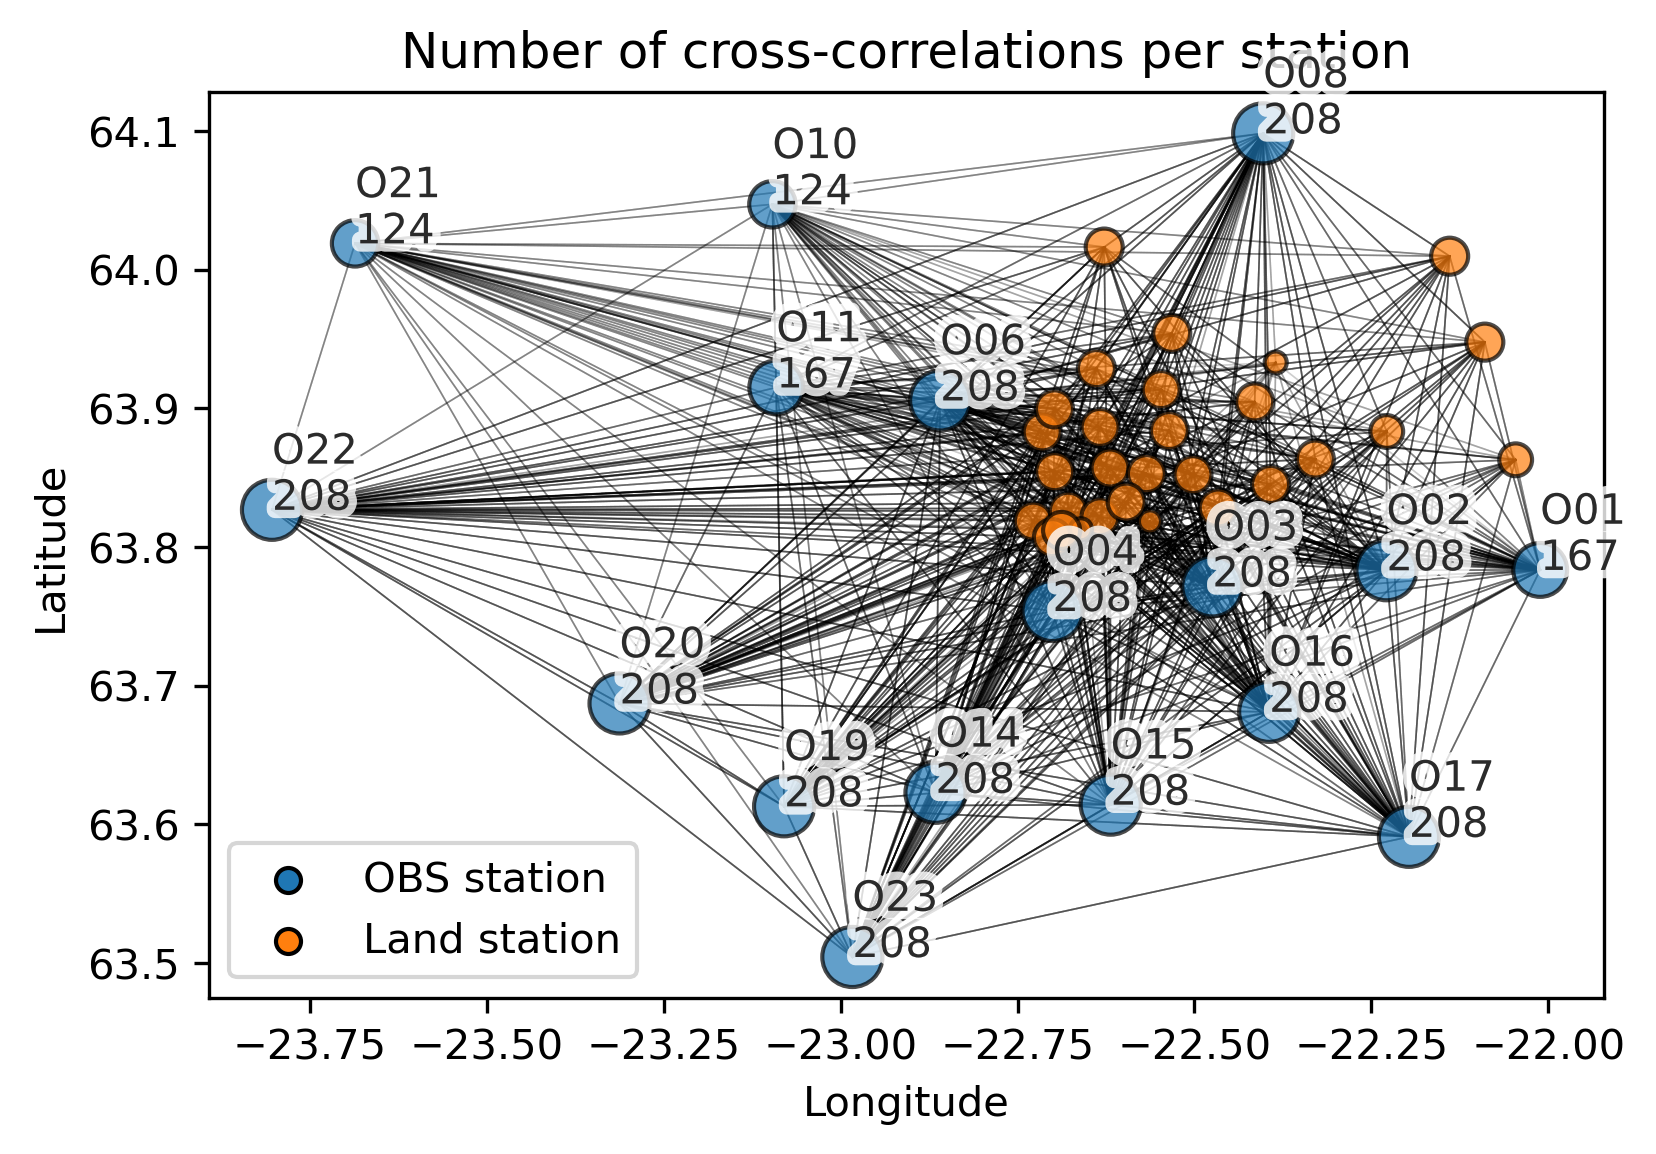

In [8]:
cd.plot_inventory_correlations()

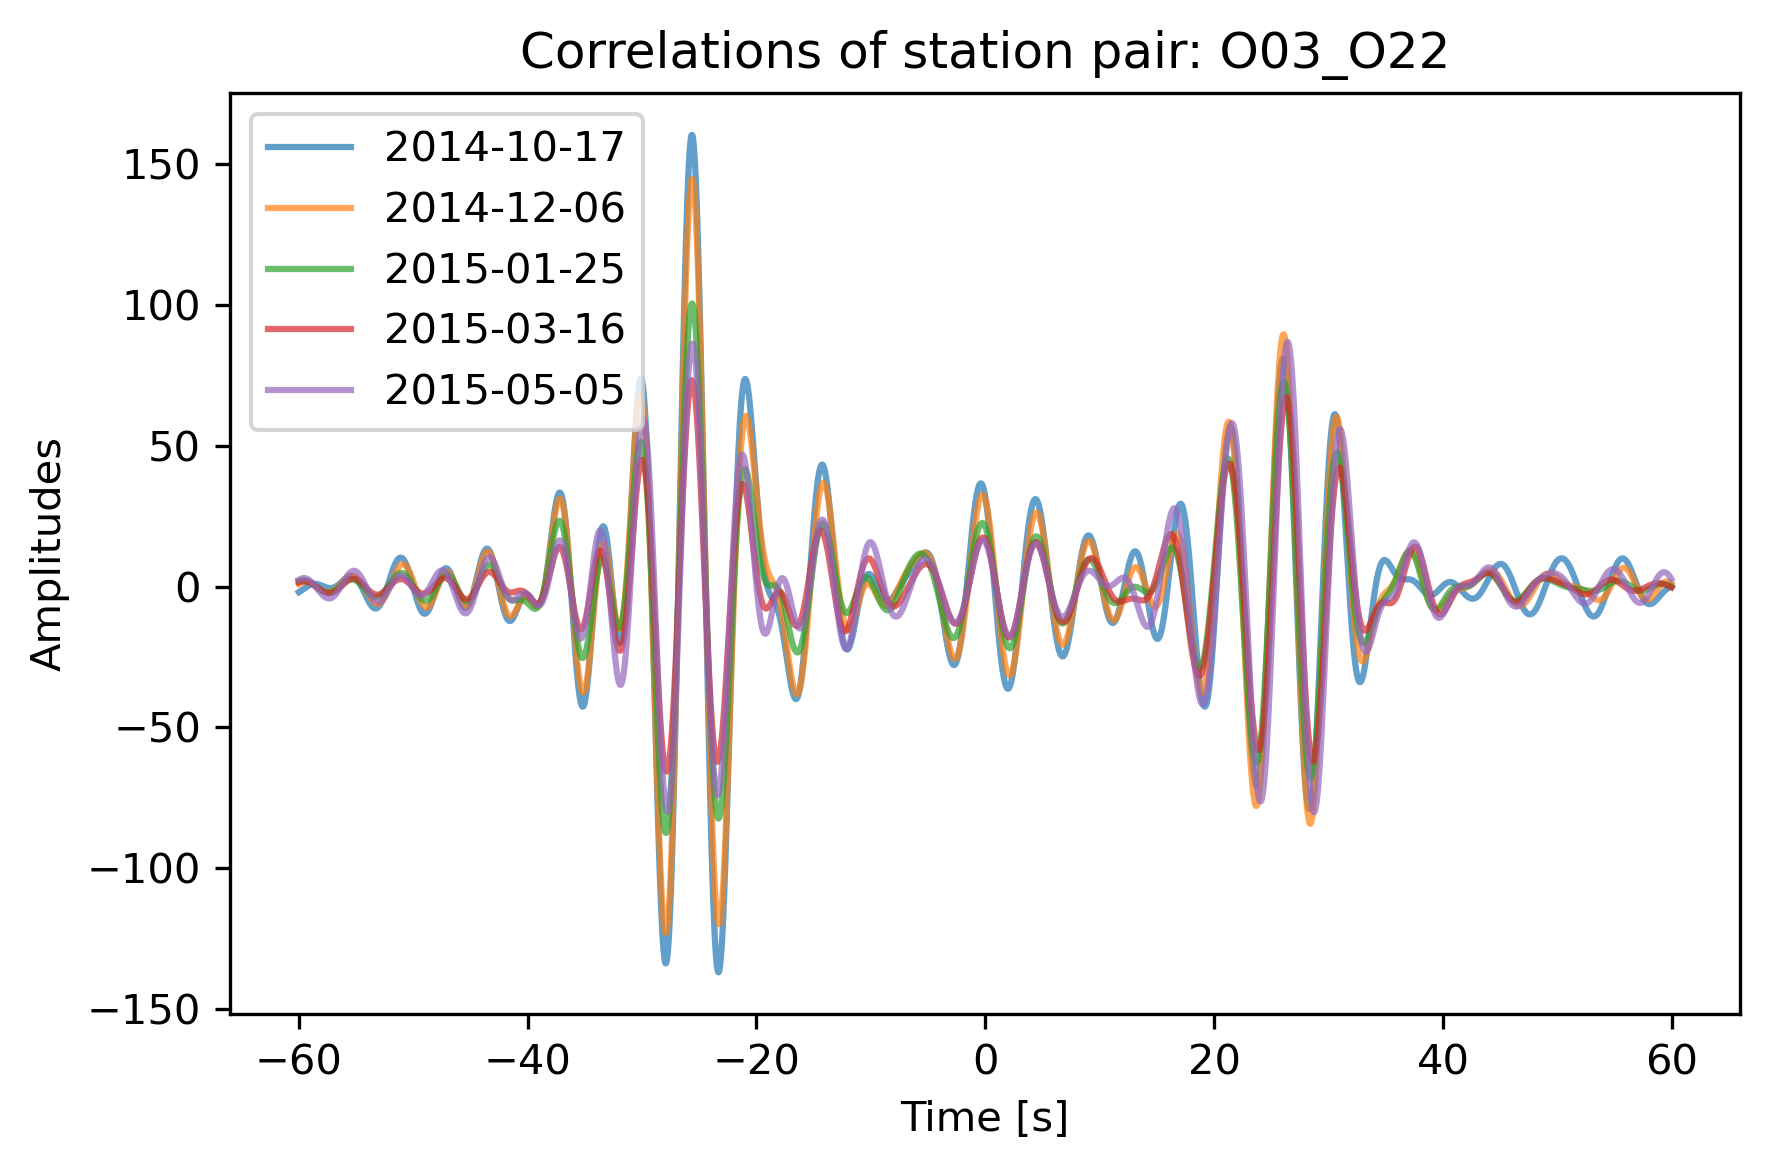

In [9]:
cd.plot_correlations_of_stationpair("O22", "O03", min_t=-60, max_t=60)